# Cello: Visualizing Multiple Correlations with Color-Coded Marginal Densities

_Note: This documentation was generated by claude.ai based on the human generated code and a discussion about the code._

## Overview

This example demonstrates how to create bivariate scatter plots with color-coded marginal density distributions using the `cello` library. The visualization technique explicitly links individual data points to their marginal distributions through connecting lines, while using color to encode a reference variable's ordering.

## Key Concept

The visualization approach is based on a simple but powerful idea:

1. **Order all observations** by a reference variable (here: petal length)
2. **Assign colors** based on rank order using a perceptually uniform colormap
3. **Apply the same color scheme** to all subsequent visualizations
4. **Assess correlation** visually: smooth color gradients indicate strong correlation with the reference variable, while mixed colors indicate weak correlation

This allows rapid visual assessment of correlation structure across multiple variable pairs without computing explicit correlation coefficients.

## Preparing the Data

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from cello import cello
from matplotlib.collections import LineCollection
from scipy.spatial import ConvexHull
import matplotlib.patches as patches 

# Load the iris dataset
iris = load_iris()
X = iris['data']

# Calculate variance for each feature to identify the most informative reference variable
variances = np.var(X, axis=0)
print("Feature variances:")
for i, name in enumerate(iris['feature_names']):
    print(f"  {name}: {variances[i]:.3f}")

# Select the feature with highest variance as reference for color ordering
# This maximizes the chance of capturing the main structure in the data
reference_feature = np.argmax(variances)
print(f"\nUsing {iris['feature_names'][reference_feature]} as reference (highest variance)")

# Create ordering based on petal length (column index 2)
# This ordering will be used to assign colors to all data points
order = np.argsort(X[:, reference_feature])

# Reorder all data according to petal length
# This ensures that the entire dataset is sorted by the reference variable
X = X[order]

# Get the 'turbo' colormap from matplotlib
# Turbo is perceptually uniform and covers a wide range of hues
cw = plt.get_cmap('turbo')

# Create color array by mapping the linear sequence [0, 1] to the turbo colormap
# This assigns colors based on the rank order (position in sorted sequence)
# Each observation gets a unique color representing its rank in petal length
colors = cw(np.linspace(0, 1, len(X)))


### Plot 0: Overview of All Features

Before examining specific bivariate relationships, we first create an overview showing all four iris features simultaneously. This provides a quick visual summary of how each feature correlates with our reference variable (petal length).


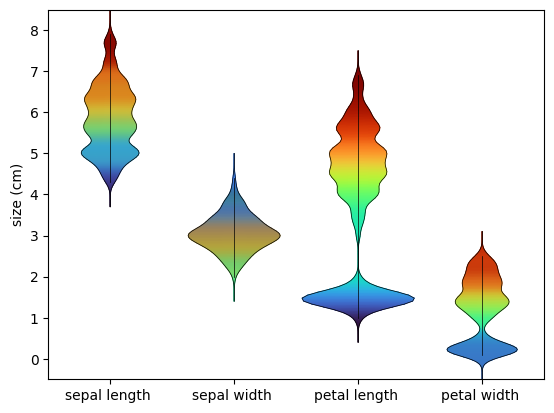

In [29]:
cello(X.T, c=colors, bw=0.2)
plt.xticks(range(1, 5), [ i[:-4] for i in iris['feature_names'] ])
plt.ylabel('size (cm)')
plt.xlim(0.5, 4.5)
plt.show()

#### Interpretation of Plot 0

This overview plot immediately reveals correlation patterns across all features:

- **Sepal length (position 1)**: Shows color stratification with some mixing—moderate correlation with petal length
- **Sepal width (position 2)**: Heavy color mixing throughout—weak correlation with petal length
- **Petal length (position 3)**: Perfect color stratification (blue→cyan→green→yellow→red)—this is our reference variable, so it shows the complete gradient
- **Petal width (position 4)**: Strong color stratification—high correlation with petal length

The multimodal distributions (visible as multiple peaks) hint at the three species structure, with color-coded regions showing which observations (by petal length) contribute to each mode.

This single plot provides a rapid assessment: petal dimensions are highly correlated with each other, while sepal dimensions show more independent variation.

---


## Creating the Visualizations

---

### Plot 1: Petal Length vs Petal Width

This plot shows the relationship between petal length (x-axis) and petal width (y-axis). Since both variables are petal measurements, we expect to see strong color stratification indicating high correlation.


#### Interpretation of Plot 1

The strong color stratification in both marginal densities reveals that:
- Petal length and petal width are **highly correlated**
- The smooth color gradient (blue → green → yellow → red) shows monotonic increase
- Three distinct species clusters are visible (convex hulls)
- Each marginal density is bimodal, with color-coded regions showing which observations contribute to each peak

---

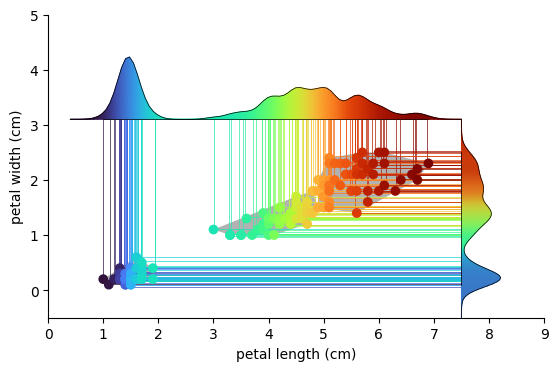

In [96]:
##############################################################################
# PLOT 1: Petal Length vs Petal Width (features 2 & 3)
##############################################################################

# Create scatter plot of petal length (x) vs petal width (y)
# Colors are assigned based on rank order of petal length (from earlier sorting)
plt.scatter(*X[:, 2:].T, c=colors)

# Add horizontal violin plot for petal length (feature 2)
# positioned at y=3.1, extending to the right of the scatter plot
# bw=0.2: kernel bandwidth for density smoothing
# scale=25: controls the width/height of the violin plot
# horizontal=True: creates a horizontal density distribution
# side='right': density curve extends rightward from the position line
x = cello(X[:, 2], c=colors, horizontal=True, position=3.1, bw=0.2, side='right', scale=25)

# Add vertical violin plot for petal width (feature 3)
# positioned at x=7.5, extending to the right of the scatter plot
# horizontal=False: creates a vertical density distribution
y = cello(X[:, 3], c=colors, horizontal=False, position=7.5, bw=0.2, side='right', scale=25)

# Create connecting lines from scatter points to horizontal marginal density (x-axis)
# X[:, [2,3,2,3]].reshape(-1, 2, 2) creates 150 line segments, each with 2 points:
#   - First point: (petal_length, petal_width) - the original scatter point
#   - Second point: (petal_length, 3.1) - projected onto the marginal position
A = X[:, [2,3,2,3]].reshape(-1, 2, 2)
A[:, 1, 1] = 3.1  # Set y-coordinate of second point to marginal position

# Add small random jitter to x-coordinates to prevent line overlap
# Jitter range: ±0.0375 (75% of 0.05)
A[:, :, 0] += 0.075*(np.random.random((150,1))-0.5)

# Create LineCollection with same colors as points, thin lines, behind scatter
A = LineCollection(A, colors=colors, linewidths=0.5, zorder=0)

# Create connecting lines from scatter points to vertical marginal density (y-axis)
# Similar structure to A, but projecting onto x=7.5
B = X[:, [2,3,2,3]].reshape(-1, 2, 2)
B[:, 1, 0] = 7.5  # Set x-coordinate of second point to marginal position

# Add small random jitter to y-coordinates to prevent line overlap
B[:, :, 1] += 0.075*(np.random.random((150,1))-0.5)

# Create LineCollection for vertical connections
B = LineCollection(B, colors=colors, linewidths=0.5, zorder=0)

# Add both line collections to the plot
plt.gca().add_artist(A)
plt.gca().add_artist(B)

# Add convex hull polygons for each iris species group
# X[:, 2:].reshape(3, -1, 2) splits the 150 points into 3 groups of 50
# (assumes data is ordered by species after the initial sorting)
for Xi in X[:, 2:].reshape(3, -1, 2):
    # Compute convex hull vertices for this species group
    hull = Xi[ConvexHull(Xi).vertices]
    
    # Create semi-transparent black polygon showing species cluster extent
    # zorder=-1 places it behind everything else
    polygon = patches.Polygon(hull, facecolor='k', closed=True, fill=True, 
                             edgecolor='none', alpha=0.3, zorder=-1)
    plt.gca().add_patch(polygon)

# Formatting: Add axis labels from iris feature names
plt.xlabel(f'{iris["feature_names"][2]}')
plt.ylabel(f'{iris["feature_names"][3]}')

# Set equal aspect ratio so distances are visually comparable
plt.gca().set_aspect('equal')

# Remove top and right spines for cleaner appearance
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set axis limits to encompass scatter and marginal plots
plt.xlim( 0, 9)
plt.ylim(-0.5, 5)

plt.show()

### Plot 2: Sepal Length vs Sepal Width

This plot shows the relationship between sepal length (x-axis) and sepal width (y-axis). We use the **same color ordering** (based on petal length) to assess how sepal measurements correlate with petal measurements.

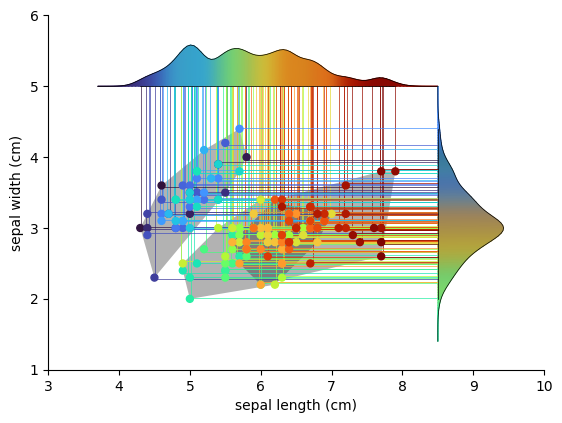

In [95]:
##############################################################################
# PLOT 2: Sepal Length vs Sepal Width (features 0 & 1)
##############################################################################

# Create scatter plot of sepal length (x) vs sepal width (y)
# Using the SAME color ordering based on petal length
# This allows visual comparison of correlation structure
plt.scatter(*X[:, :2].T, c=colors, s=25)

# Add horizontal violin plot for sepal length (feature 0)
# positioned at y=5, extending to the right
cello(X[:, 0], c=colors, horizontal=True, position=5, bw=0.2, side='right', scale=25)

# Add vertical violin plot for sepal width (feature 1)
# positioned at x=8.5, extending to the right
cello(X[:, 1], c=colors, horizontal=False, position=8.5, bw=0.2, side='right', scale=25)

# Create connecting lines from scatter points to horizontal marginal (x-axis)
# Same logic as Plot 1, but for sepal measurements
A = X[:, [0,1,0,1]].reshape(-1, 2, 2)
A[:, 1, 1] = 5  # Project onto y=5 (marginal position)
A[:, :, 0] += 0.075*(np.random.random((150,1))-0.5)  # Add jitter
A = LineCollection(A, colors=colors, linewidths=0.5, zorder=0)

# Create connecting lines from scatter points to vertical marginal (y-axis)
B = X[:, [0,1,0,1]].reshape(-1, 2, 2)
B[:, 1, 0] = 8.5  # Project onto x=8.5 (marginal position)
B[:, :, 1] += 0.075*(np.random.random((150,1))-0.5)  # Add jitter
B = LineCollection(B, colors=colors, linewidths=0.5, zorder=0)

# Add line collections to plot
plt.gca().add_artist(A)
plt.gca().add_artist(B)

# Add convex hull polygons for each species in sepal space
# X[:, :2].reshape(3, -1, 2) splits sepal measurements into 3 species groups
for Xi in X[:, :2].reshape(3, -1, 2):
    hull = Xi[ConvexHull(Xi).vertices]
    polygon = patches.Polygon(hull, facecolor='k', closed=True, fill=True, 
                             edgecolor='none', alpha=0.3, zorder=-1)
    plt.gca().add_patch(polygon)

# Formatting: Add axis labels
plt.xlabel(f'{iris["feature_names"][0]}')
plt.ylabel(f'{iris["feature_names"][1]}')

# Equal aspect ratio for visual comparability
plt.gca().set_aspect('equal')

# Clean appearance
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set axis limits to encompass scatter and marginal plots
plt.xlim( 3, 10)
plt.ylim( 1, 6)

plt.show()


#### Interpretation of Plot 2

The extensive color mixing in the marginal densities reveals that:
- Sepal measurements have **weaker correlation** with petal length
- Colors are thoroughly mixed in both marginals (all hues appear throughout)
- Species clusters show more overlap in sepal space
- The relationship between sepal and petal measurements is more complex

---

## Key Technical Features

### Color-Weighted Kernel Density Estimation

The `cello` function computes kernel density estimates where each point's color contribution is weighted by its kernel density at that location. At position *y* on a density curve, the color is:

$$C(y) = \frac{\sum_i K_h(y - y_i) \cdot \text{color}_i}{\sum_i K_h(y - y_i)}$$

This reveals the **compositional structure** of the density—showing which observations (by their reference variable values) contribute to each region of the distribution.

### Connecting Lines with Jitter

The connecting lines explicitly show how each scatter point projects onto its marginal distributions. Random jitter (`±0.0375` units) prevents visual overlap while maintaining clear point-to-marginal associations.

### Visual Correlation Assessment

- **Smooth color gradient**: Strong positive correlation with reference variable
- **Inverted gradient**: Strong negative correlation  
- **Mixed colors**: Weak or no correlation
- **Localized color bands**: Conditional or nonlinear relationships

## Applications

This visualization approach is particularly powerful for:

- **PCA interpretation**: Color observations by PC1 scores, then visualize other PCs or original variables to see which capture the same variance structure
- **Feature selection**: Quickly identify which variables correlate with an outcome of interest
- **Quality control**: Detect batch effects or technical artifacts by coloring by batch and checking if biological variables show unwanted color stratification
- **Hypothesis generation**: Screen many variable pairs efficiently to identify relationships worth deeper investigation

## Advantages Over Traditional Approaches

| Approach | Information Provided | Scalability |
|----------|---------------------|-------------|
| **Scatterplot matrix** | Pairwise relationships | O(n²) visual space |
| **Correlation heatmap** | Summary statistics only | Compact but loses distributional detail |
| **This approach** | Distributional + correlation structure | O(n) when using fixed reference variable |

By fixing one reference variable for color encoding and displaying each additional variable as a single density plot, you can screen dozens of variables on a single dashboard while preserving full distributional information and correlation structure.